<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

![Allos_logo](resources/logo_allos.png)

Single-cell RNA sequencing (scRNA-seq) has revolutionized our understanding of cellular diversity by allowing the study of gene expression at the individual cell level. However, traditional methods of quantification obscure the most fine-grained transcriptional layer—the individual transcripts at sequence-level resolution—in favor of gene-level binning. This strategy is useful when the sequencing read length is short, as it avoids the difficult task of transcript assembly, which is made even more challenging by the nature of single-cell data.

Traditional scRNA-seq methods often rely on short-read sequencing technologies, which can limit the ability to resolve full-length transcripts and isoforms. Long-read sequencing technologies, such as those provided by Oxford Nanopore and PacBio, overcome this limitation by producing reads that span entire transcripts. This capability is crucial for accurately identifying and characterizing novel isoforms and understanding the complexity of transcriptomes in single cells. By integrating long-read sequencing with single-cell approaches, researchers can gain deeper insights into cellular heterogeneity and the functional implications of transcriptomic variations.

Allos is designed to give users familiar with single-cell analysis, and indeed object-oriented programming in general, an extended toolkit wrapping around Scanpy and the wider scverse to facilitate analysis workflows of this type of data. Allos is the culmination of many smaller individualized scripts packaged together into a common framework centered on anndata objects. It also contains many recreations (of varying faithfulness to their originals*) of functions proposed by others in other libraries, languages, or contexts—we by no means intend to plagiarize these methods but only expand them to a wider audience.

Allos intends to offer a full suite of modules for every step of single-cell isoform resolution data, from preprocessing, working with annotations, plotting, identifying differential features, isoform switches, and more. We hope to expand Allos with the input of our user base as the field of long-read single-cell further matures.

## Install

```sh
pip install allos
```

## Basic workflow


 The first thing we need to work with Allos is data. Our goal is for Allos to handle many, if not all, types of single-cell isoform resolution data, making it platform and protocol agnostic. While it is important to consider the biases, strengths, limitations, and caveats of each approach, all methods utilize a transcript matrix from which a gene matrix can be derived. Allos also allows users to supply their own custom annotations in the form of a GTF or use a reference annotation. If a reference annotation is provided, all plotting functions will use the underlying GTF to retrieve the transcript information.

 To help you follow the basic workflow, we provide an easy way to download one of our test datasets. The Sicelore dataset comprises 1,121 single-cell transcriptomes from two technical replicates derived from an embryonic day 18 (E18) mouse brain, consisting of 951 cells and 190 cells. The dataset was generated using the 10x Genomics Chromium system and sequenced with both Oxford Nanopore and Illumina platforms, producing 322 million Nanopore reads and 70 million Illumina reads for the 951-cell replicate, and 32 million Nanopore reads with 43 million Illumina reads for the 190-cell replicate. The dataset captured a median of 2,427 genes and 6,047 UMIs per cell, enabling the identification of 33,002 annotated transcript isoforms and 4,388 novel isoforms. Major cell types in the dataset include radial glia, cycling radial glia, intermediate progenitors, Cajal-Retzius cells, and maturing GABAergic and glutamatergic neurons, providing a detailed resource for studying transcriptome-wide alternative splicing, isoform expression, and sequence diversity during mouse brain development.

In [1]:
import allos.preprocessing as pp
sicelore_mouse_data = pp.process_mouse_data()


🔎 Looking for file at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File found at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz to /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt...
✅ Decompression complete.
Test data (mouse_1) downloaded successfully
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz to 

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In this dataset, we observe the mouse data organized in a cell-by-transcript matrix format. This structure allows us to examine the expression levels of individual transcripts across different cells. Additionally, each transcript is associated with a specific gene, providing a hierarchical view of gene expression. This organization is crucial for understanding the relationship between transcripts and their corresponding genes.

In [2]:
sicelore_mouse_data

View of AnnData object with n_obs × n_vars = 1109 × 31986
    obs: 'batch', 'cell_type'
    var: 'geneId'

In [3]:
print(sicelore_mouse_data.var.head(10))

                       geneId
transcriptId                 
ENSMUST00000156717.1     Klc2
ENSMUST00000212520.1   Capn15
ENSMUST00000025798.12    Klc2
ENSMUST00000231280.1    Eva1c
ENSMUST00000039286.4     Atg5
ENSMUST00000144552.7   Znhit3
ENSMUST00000112304.8    Ppm1b
ENSMUST00000162041.7     Gcc2
ENSMUST00000053506.6     Bbs1
ENSMUST00000028207.12    Crat


IsoAdata objects can be used just like normal anndata objects, lets take a look.

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 5000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


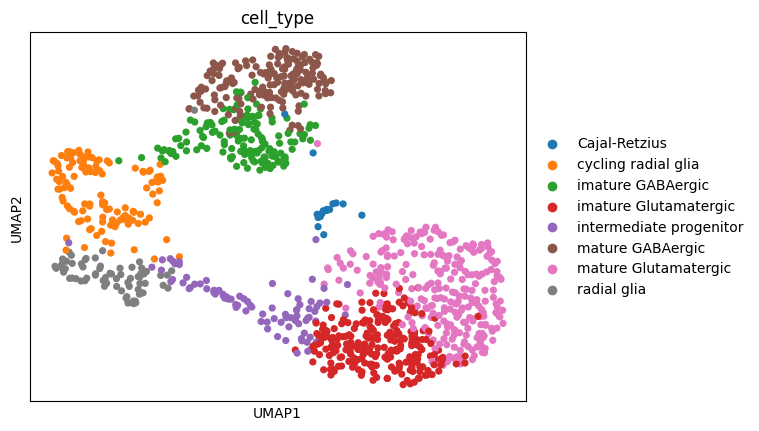

In [4]:
import scanpy as sc

# Make a copy of the original data to preserve it
original_sicelore_mouse_data = sicelore_mouse_data.copy()

# Perform the operations
sc.pp.normalize_total(sicelore_mouse_data, target_sum=1e6)
sc.pp.log1p(sicelore_mouse_data)

# Select the top 5000 highly variable genes
sc.pp.highly_variable_genes(sicelore_mouse_data, n_top_genes=5000)
sicelore_mouse_data = sicelore_mouse_data[:, sicelore_mouse_data.var.highly_variable]

sc.pp.neighbors(sicelore_mouse_data)
sc.tl.umap(sicelore_mouse_data)
sc.pl.umap(sicelore_mouse_data, color='cell_type')

# Restore the original data
sicelore_mouse_data = original_sicelore_mouse_data

We can easily collapse the transcript matrix to a gene matrix and see how the dimensionality reduction plot differs.

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 5002 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


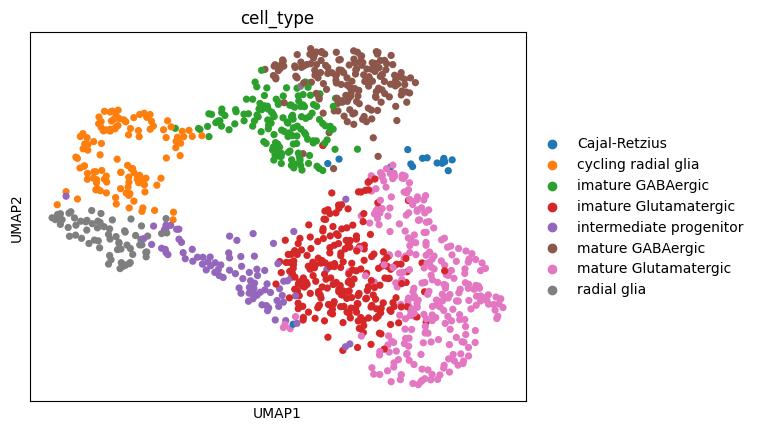

In [5]:
import allos.preprocessing as pp

gene_anndata = pp.get_sot_gene_matrix(sicelore_mouse_data)

# Make a copy of the gene matrix data to preserve it
original_gene_anndata = gene_anndata.copy()

# Perform the operations on the gene matrix
sc.pp.normalize_total(gene_anndata, target_sum=1e6)
sc.pp.log1p(gene_anndata)

# Select the top 5000 highly variable genes for gene_anndata
sc.pp.highly_variable_genes(gene_anndata, n_top_genes=5000)
gene_anndata = gene_anndata[:, gene_anndata.var.highly_variable]

sc.pp.neighbors(gene_anndata)
sc.tl.umap(gene_anndata)
sc.pl.umap(gene_anndata, color='cell_type')

# Restore the original gene matrix data
gene_anndata = original_gene_anndata

Lets take a look at the most differentially exspressed genes accross the already annotated cell types 

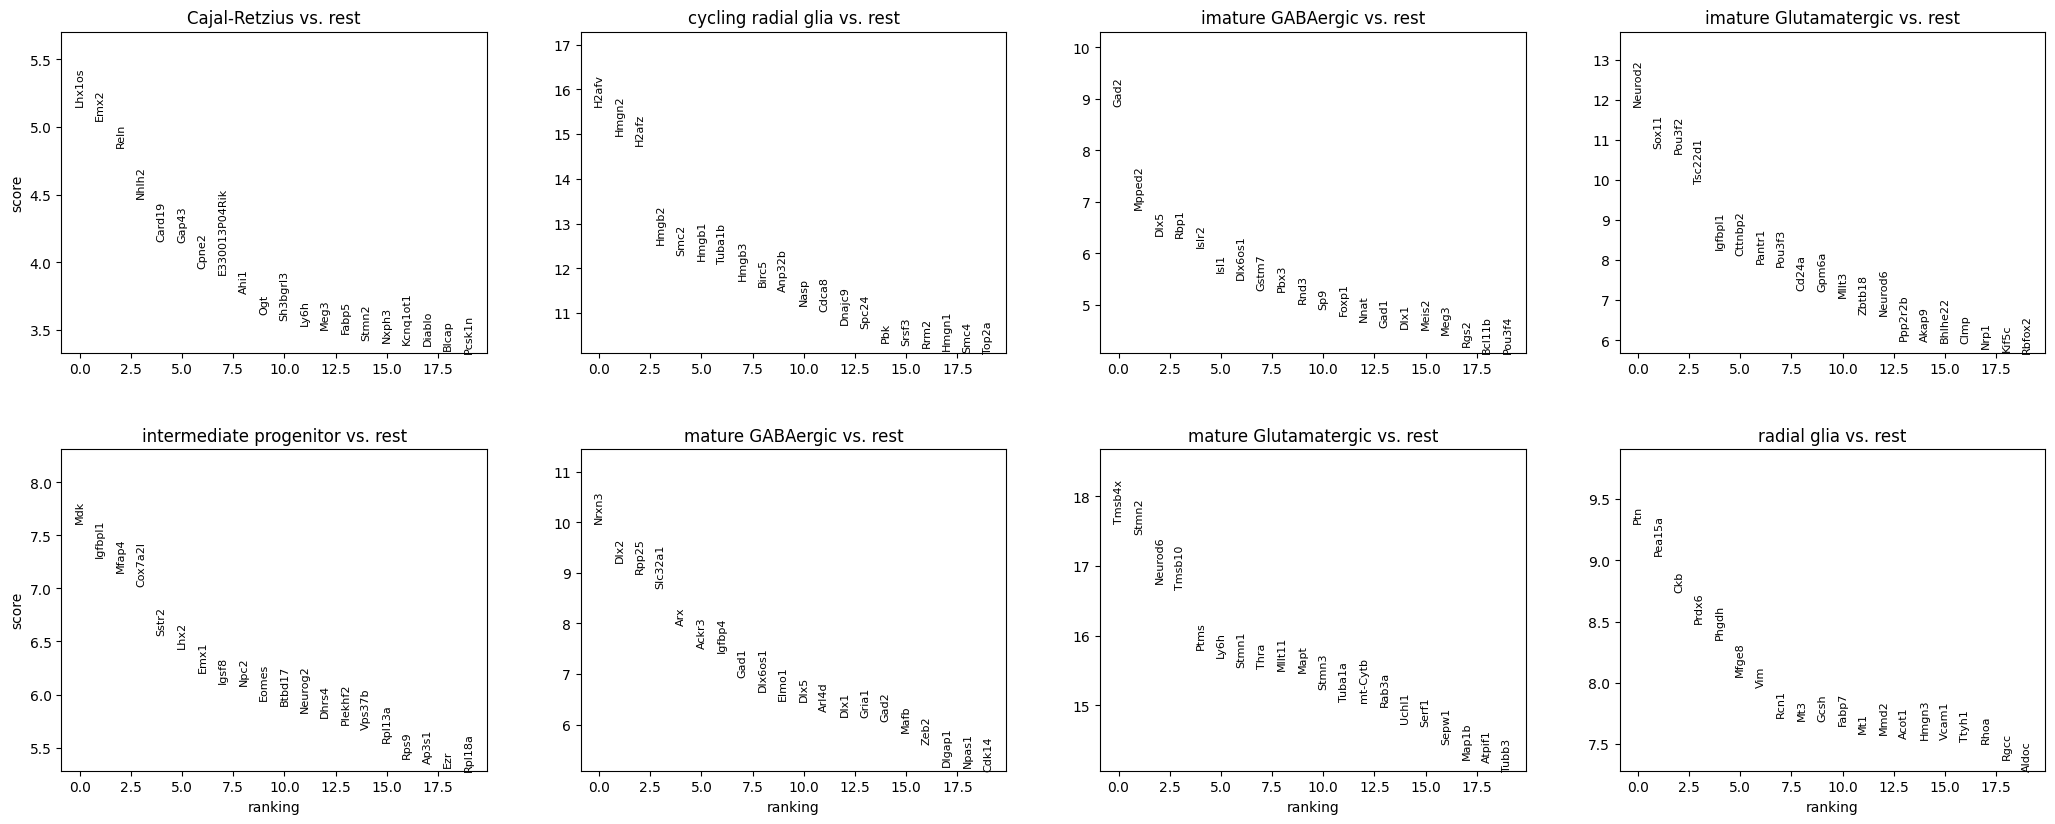

In [6]:
# Perform differential expression analysis to rank genes on the gene matrix
sc.tl.rank_genes_groups(gene_anndata, 'cell_type', method='t-test')

# Plot the ranked gene groups with adjusted figure size
sc.pl.rank_genes_groups(gene_anndata, n_genes=20, sharey=False, figsize=(12, 10))

Now lets look at fifferentially exspressed transcripts.

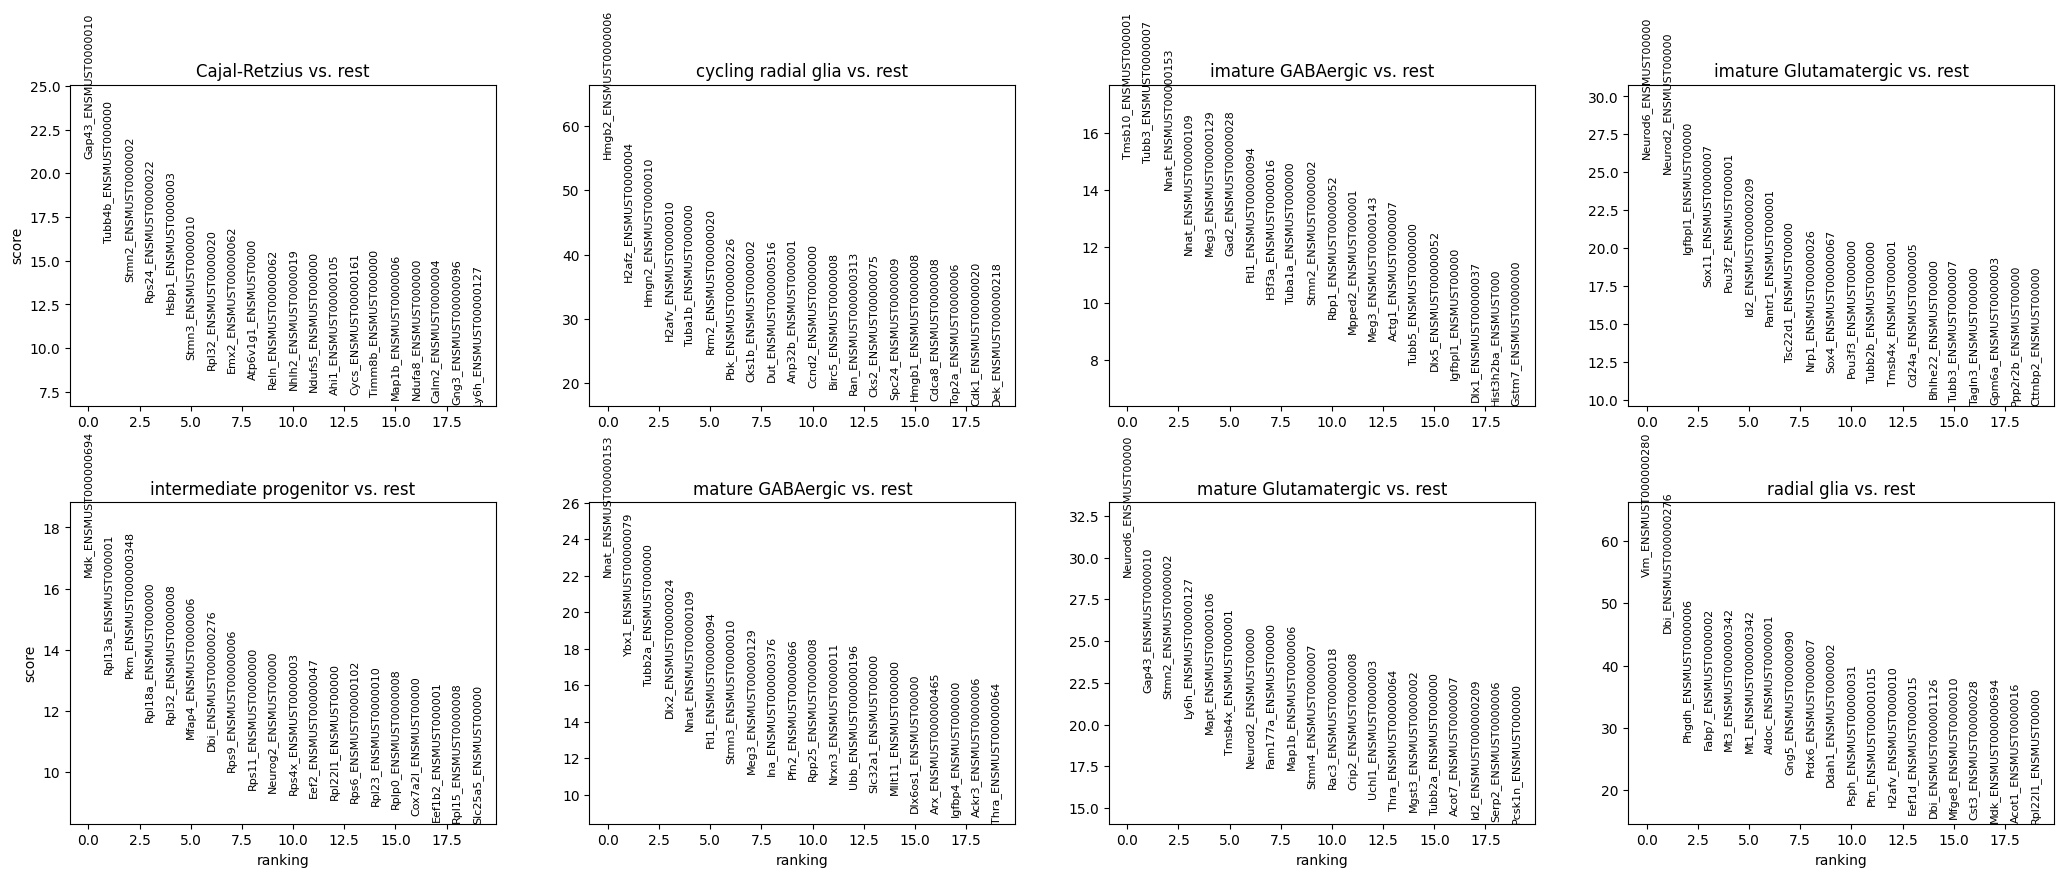

In [7]:
# Concatenate the gene name before the transcript ID in the transcript matrix
transcript_matrix = sicelore_mouse_data.copy()

# Convert 'geneId' to string to avoid TypeError when concatenating with index
transcript_matrix.var['geneId'] = transcript_matrix.var['geneId'].astype(str)

# Assuming 'gene_name' and 'transcript_id' are columns in the var DataFrame of the AnnData object
transcript_matrix.var['gene_transcript_id'] = transcript_matrix.var['geneId'] + '_' + transcript_matrix.var.index.astype(str)

# Truncate the gene_transcript_id to fit better in plots
transcript_matrix.var['gene_transcript_id'] = transcript_matrix.var['gene_transcript_id'].str.slice(0, 20)

# Update the var index to use the new truncated gene_transcript_id
transcript_matrix.var.index = transcript_matrix.var['gene_transcript_id']

# Log transform and CPM normalize the transcript matrix
sc.pp.normalize_total(transcript_matrix, target_sum=1e6)
sc.pp.log1p(transcript_matrix)

# Perform differential expression analysis to rank genes on the transcript matrix
sc.tl.rank_genes_groups(transcript_matrix, 'cell_type', method='t-test')

# Plot the ranked gene groups with adjusted figure size
sc.pl.rank_genes_groups(transcript_matrix, n_genes=20, sharey=False, figsize=(12, 10))

In [8]:
# Perform the operations on a copy of the sicelore_mouse_data
sicelore_mouse_data_copy = sicelore_mouse_data.copy()

sc.pp.normalize_total(sicelore_mouse_data_copy, target_sum=1e6)
sc.pp.log1p(sicelore_mouse_data_copy)

sc.pp.neighbors(sicelore_mouse_data_copy)
sc.tl.umap(sicelore_mouse_data_copy)

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 31986 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


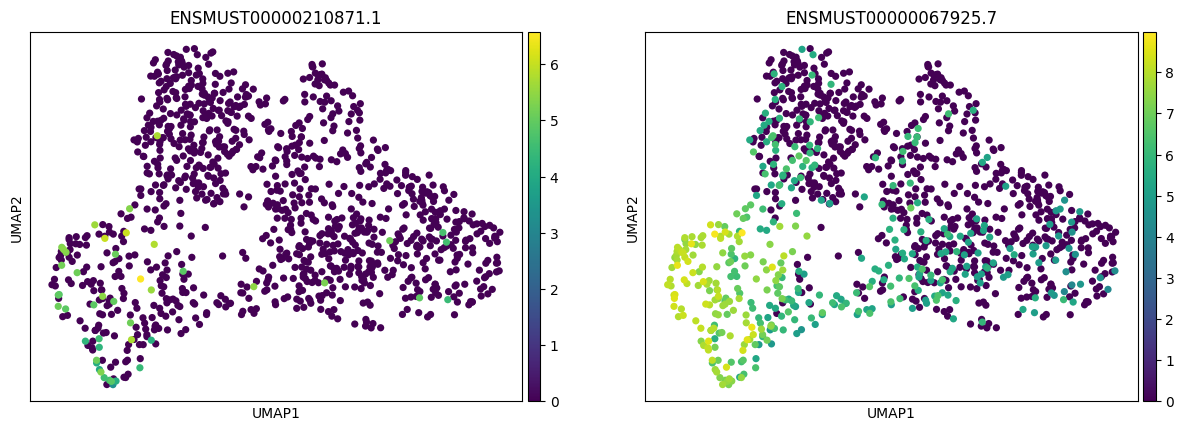

In [11]:
import allos.visuals as vs
vs.plot_transcripts(sicelore_mouse_data_copy, gene_id='Hmgb2')

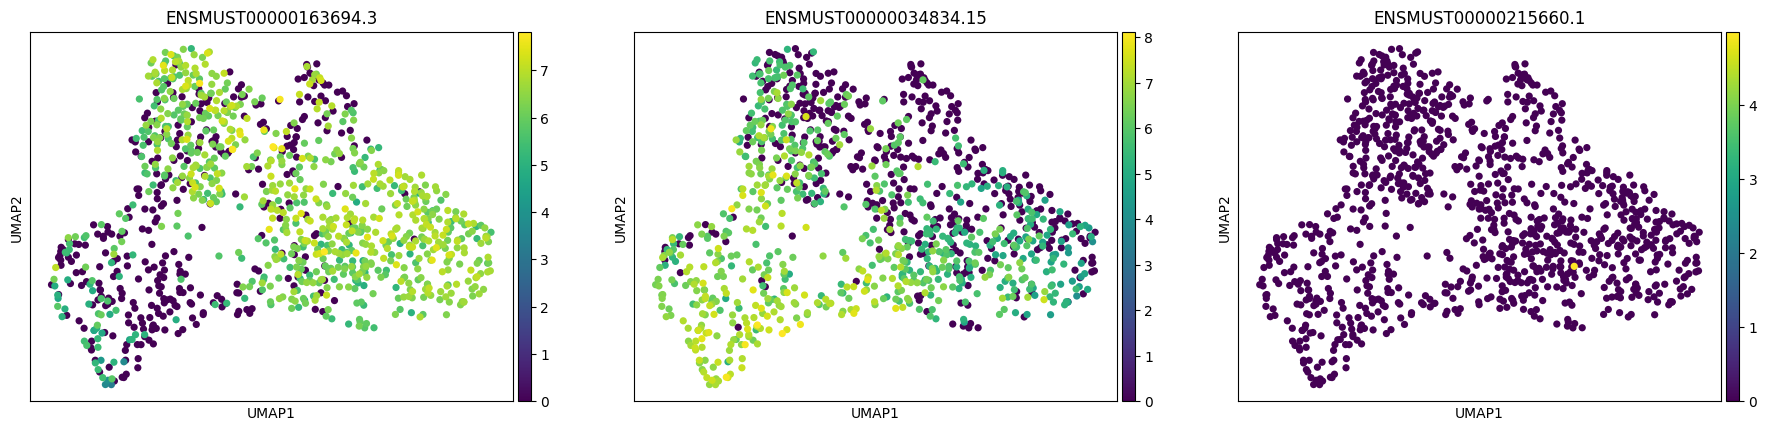

In [13]:
import allos.visuals as vs
vs.plot_transcripts(sicelore_mouse_data_copy, gene_id='Pkm')

In [15]:
from allos.switch_search import SwitchSearch

In [16]:
ss = SwitchSearch(sicelore_mouse_data)

In [18]:
switch_list = ss.find_switching_isoforms_wilcoxon(n_jobs=10)

In [22]:
switch_list.head(20)

,transcript_id,scores,log_fold_change,pvals,pvals_adj,group_1,group_2,contrast,gene_id,n_cells_group_1,n_cells_group_2,total_cells,p_value,direction,percent_expressed_group_1,percent_expressed_group_2
5943,ENSMUST00000034834.15,12.270655,5.354527,1.301969e-34,1.156799e-31,cycling radial glia,mature Glutamatergic,cycling radial glia__mature Glutamatergic,Pkm,117,275,392,7.113057e-29,5.354527,88.888889,42.181818
5944,ENSMUST00000163694.3,11.957458,5.027552,5.935075e-33,4.630227e-30,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Pkm,275,117,392,2.160587e-27,-5.027552,89.818182,43.589744
5959,ENSMUST00000034834.15,11.984186,5.965338,4.300464e-33,2.751093e-29,intermediate progenitor,mature Glutamatergic,intermediate progenitor__mature Glutamatergic,Pkm,86,275,361,1.154418e-26,5.965338,94.186047,42.181818
1486,ENSMUST00000107849.9,11.684690,5.028407,1.526343e-31,1.038757e-28,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Clta,275,117,392,3.982160e-26,-5.028407,87.636364,39.316239
5966,ENSMUST00000034834.15,11.383351,6.386945,5.061634e-30,5.996349e-27,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Pkm,68,275,343,1.591441e-24,-6.386945,95.588235,42.181818
5965,ENSMUST00000163694.3,11.155944,8.147258,6.697808e-29,6.121031e-26,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Pkm,275,68,343,1.333826e-23,8.147258,89.818182,16.176471
1506,ENSMUST00000107849.9,10.725714,8.949328,7.708972e-27,5.360417e-24,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Clta,275,68,343,9.377558e-22,8.949328,87.636364,7.352941
2235,ENSMUST00000154584.8,10.596644,6.462344,3.088641e-26,1.975866e-23,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Eef1d,68,275,343,3.237709e-21,-6.462344,89.705882,24.727273
5940,ENSMUST00000163694.3,10.560711,4.567454,4.532153e-26,3.221454e-23,imature Glutamatergic,cycling radial glia,cycling radial glia__imature Glutamatergic,Pkm,234,117,351,5.183036e-21,-4.567454,84.615385,43.589744
1130,ENSMUST00000030417.9,10.449820,7.487224,1.468039e-25,8.695686e-23,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Cdc42,275,68,343,1.304437e-20,7.487224,85.090909,14.705882


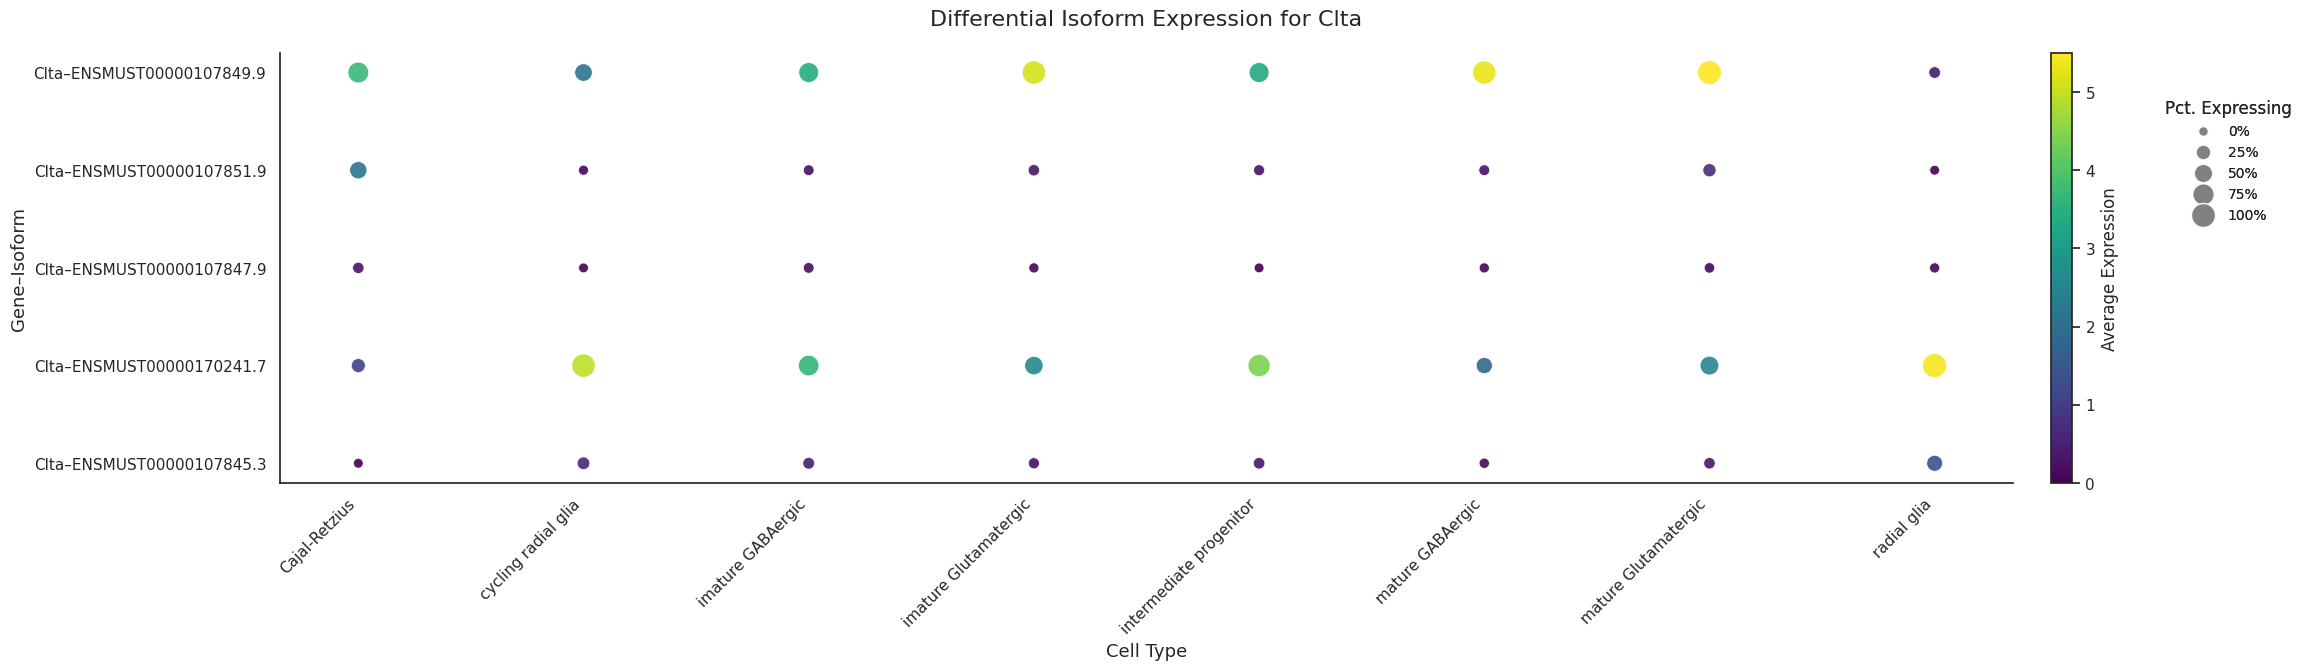

In [20]:
vs.plot_transcript_exspression_dotplot(sicelore_mouse_data_copy, gene_id='Clta')

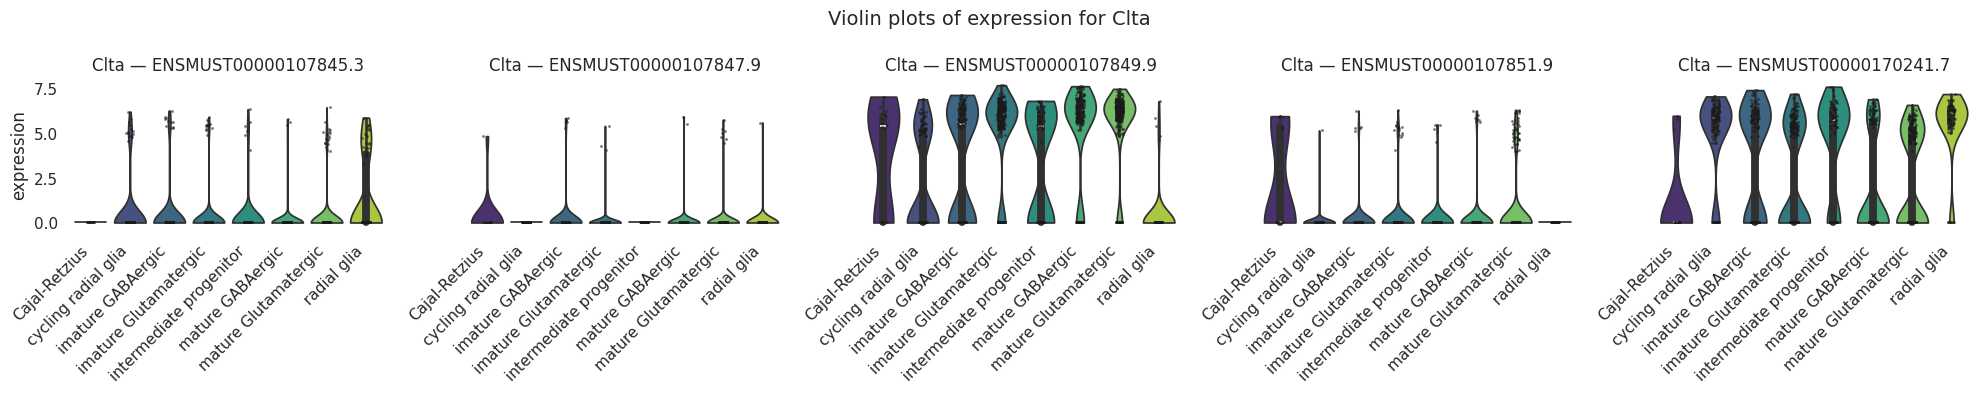

In [21]:
vs.plot_transcript_expression_violin(sicelore_mouse_data_copy, gene_id='Clta')

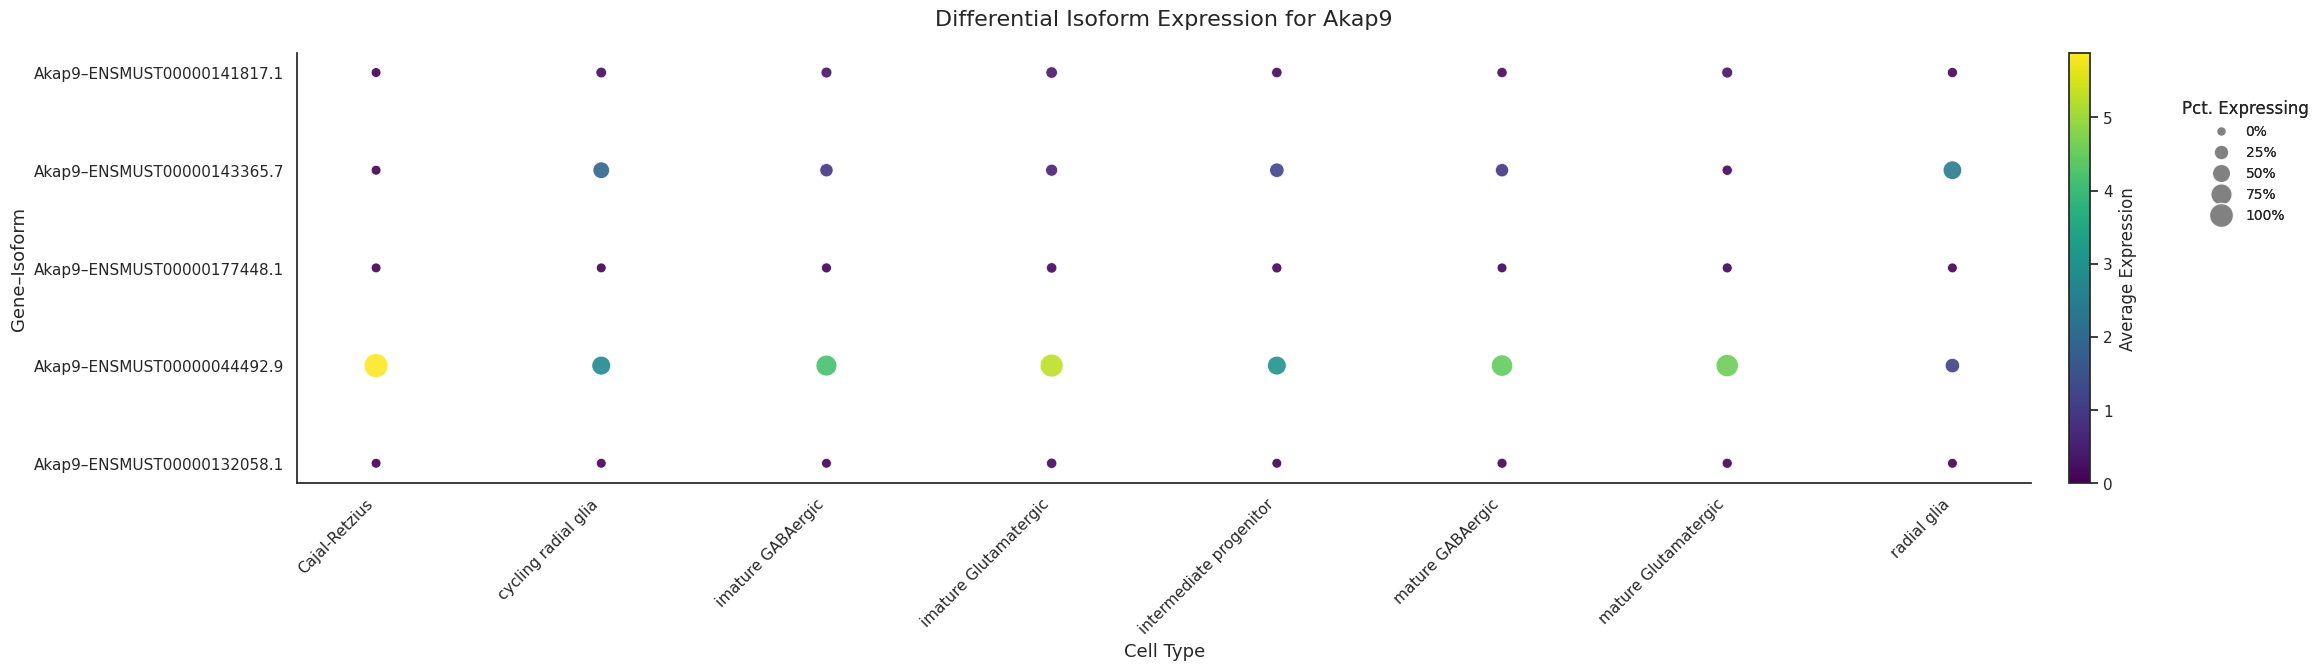

In [23]:
vs.plot_transcript_exspression_dotplot(sicelore_mouse_data_copy, gene_id='Akap9')

In [24]:
import os
import urllib.request
from pathlib import Path

# Example Ensembl URLs for mouse GRCm39 (release 109)
gtf_url = "ftp://ftp.ensembl.org/pub/release-109/gtf/mus_musculus/Mus_musculus.GRCm39.109.gtf.gz"

# Store data one directory back
data_dir = Path("..") / "data"
data_dir.mkdir(parents=True, exist_ok=True)

gtf_file_local = data_dir / "Mus_musculus.GRCm39.109.gtf.gz"

# Download if not already present
if not gtf_file_local.is_file():
    print(f"Downloading {gtf_url}...")
    urllib.request.urlretrieve(gtf_url, gtf_file_local)

In [26]:
from allos.transcript_plots import TranscriptPlots

tp = TranscriptPlots(gtf_file= gtf_file_local)

In [28]:
from allos.switch_search import get_top_n_isoforms

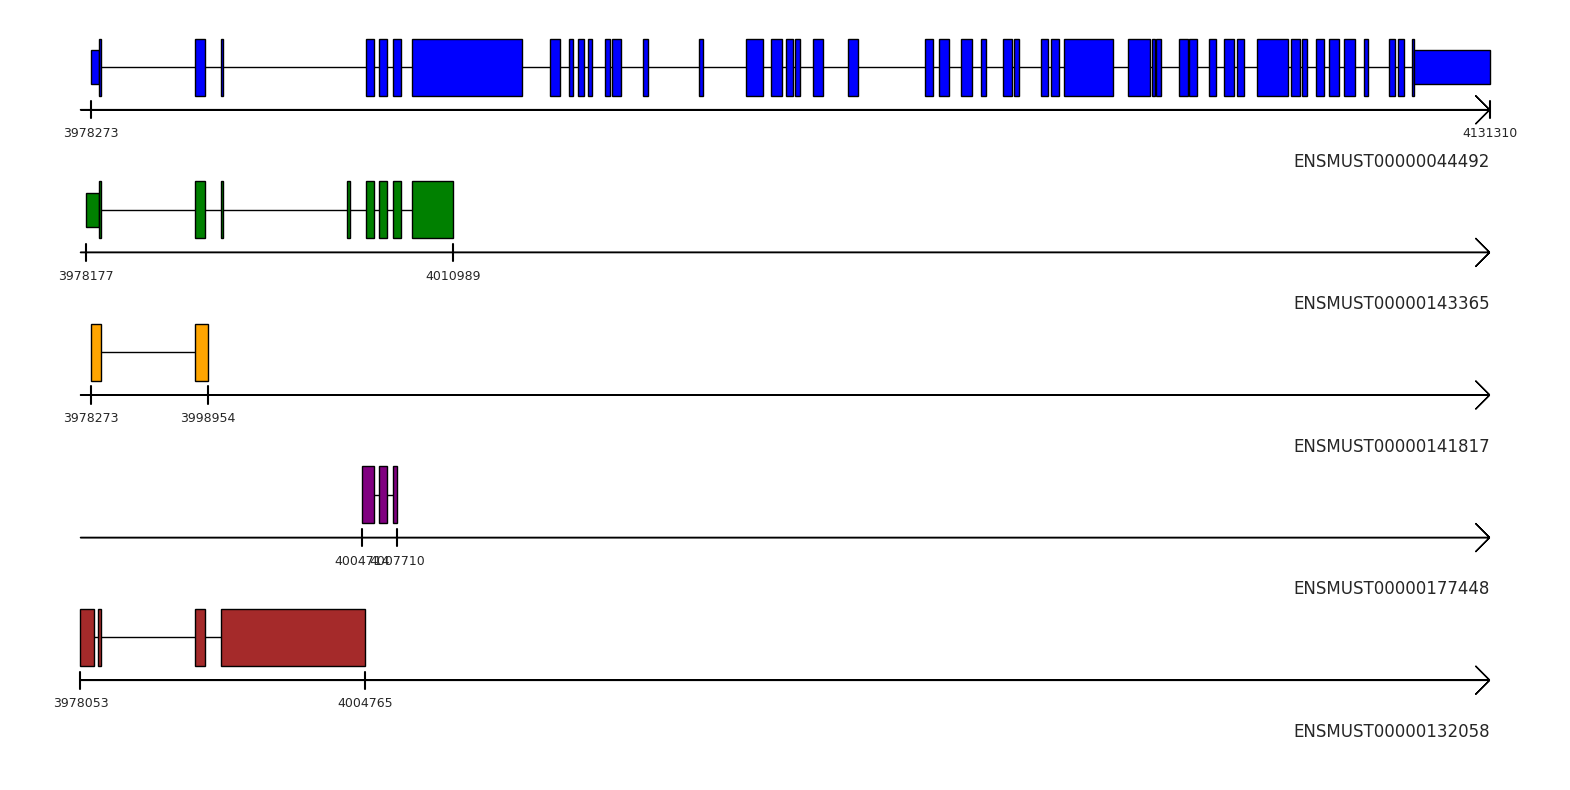

In [34]:
top_n = get_top_n_isoforms(sicelore_mouse_data_copy, gene_id='Akap9', strip=True)
tp.draw_transcripts_list(top_n, draw_cds=True)

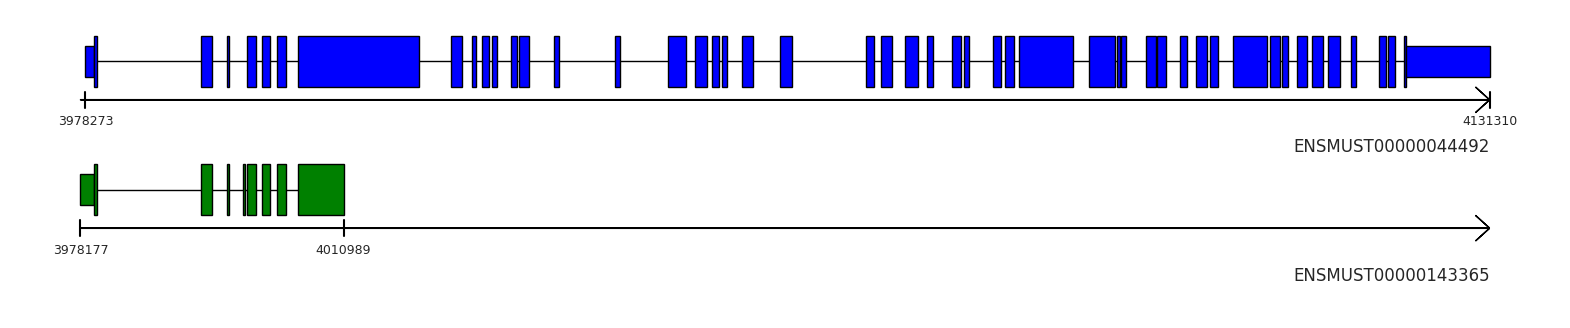

In [35]:
top_n = get_top_n_isoforms(sicelore_mouse_data_copy, gene_id='Akap9', strip=True, top_n=2)
tp.draw_transcripts_list(top_n, draw_cds=True)

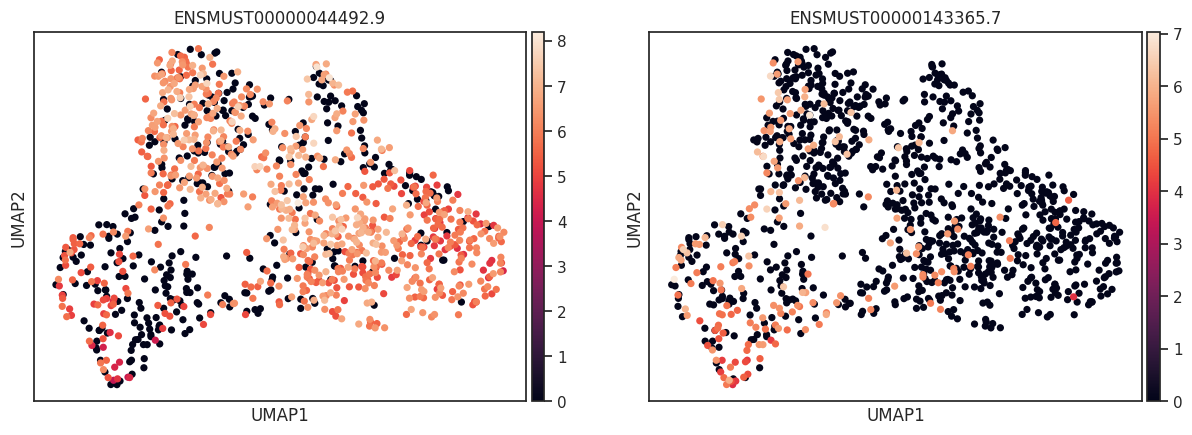

In [40]:
top_n = get_top_n_isoforms(sicelore_mouse_data_copy, gene_id='Akap9', strip=False, top_n=2)

vs.plot_transcripts(sicelore_mouse_data_copy, transcripts=top_n)

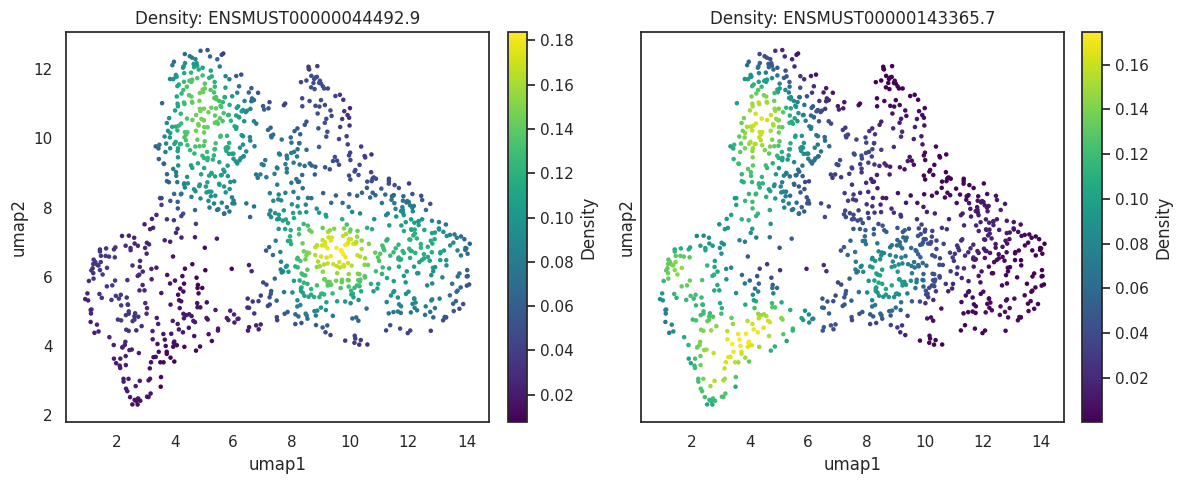

In [41]:
vs.plot_density_multi(sicelore_mouse_data_copy, features=top_n)